In [1]:
import sys
!{sys.executable} -m pip install statsmodels

  Using cached patsy-1.0.1-py2.py3-none-any.whl.metadata (3.3 kB)
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   --------------------------- ------------ 6.8/9.8 MB 38.1 MB/s eta 0:00:01
   ---------------------------------------- 9.8/9.8 MB 36.2 MB/s eta 0:00:00
Using cached patsy-1.0.1-py2.py3-none-any.whl (232 kB)

   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [stat

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

Combine the csv file of all Clustered color profile and video metrics using the Video ID 

In [3]:
# Combine all Cluster data and color profile percentage into one DataFrame
color_profile_data = pd.read_csv('Final_Clustering/K=9/Cluster_Color_Profile_Final.csv')

# Load video engagement data
video_data = pd.read_csv('Final_Clustering/Results_Count_Final.csv')

Get rid of the '.jpg' in the video ID in Clustered Color Profile

In [4]:
# Remove the .jpg extension from the VideoID in color_profile_data
color_profile_data['VideoID'] = color_profile_data['VideoID'].str.replace('.jpg', '')

# Check again after cleaning
print("\nCleaned Sample IDs from color_profile_data:")
print(color_profile_data['VideoID'].head())


Cleaned Sample IDs from color_profile_data:
0    --8n6A8Q6M0
1    -0FfyNZdHk0
2    -1B7cVoZr1c
3    -4yu_13EHFM
4    -6FvAU9H98w
Name: VideoID, dtype: object


In [5]:
# Display the first few rows of both datasets
print("\nClustered Color Profile Data:")
print(color_profile_data.head())
print("\nNumber of rows and columns in text_data:", color_profile_data.shape)

print("\nVideo Engagement Data:")
print(video_data.head())
print("\nNumber of rows and columns in video_data:", video_data.shape)


Clustered Color Profile Data:
       VideoID  Yellow  Orange  Red  Violet  Blue  Green  Black  White  Brown  \
0  --8n6A8Q6M0    0.00    0.71  0.0   23.29  0.06   0.00  13.58  13.01  49.35   
1  -0FfyNZdHk0    0.01    0.97  0.0   11.65  0.00   8.13  26.25  13.26  39.73   
2  -1B7cVoZr1c    0.84    0.61  0.0   16.56  7.08   0.00  14.65  32.05  28.21   
3  -4yu_13EHFM    0.00    8.72  0.0   25.99  0.00   0.00  14.83  10.53  39.93   
4  -6FvAU9H98w    0.11   10.24  0.7    6.79  0.04   0.00  12.74  39.01  30.37   

   Cluster  
0        1  
1        5  
2        2  
3        1  
4        2  

Number of rows and columns in text_data: (2587, 11)

Video Engagement Data:
       VideoID  View Count  Like Count  Comment Count
0  --8n6A8Q6M0      338385       11044           1371
1  -0FfyNZdHk0         147           4              1
2  -1B7cVoZr1c      150876        3011            225
3  -4yu_13EHFM       28277        1158            381
4  -6FvAU9H98w       63409        1277            110

Nu

In [6]:
# Merge datasets on 'Video ID'
merged_data = pd.merge(color_profile_data, video_data, on='VideoID', how='inner')

# Read the results_final.csv file
results_df = pd.read_csv('results_final.csv')

# Rename the 'Video Id' column to 'VideoID' in results_df to match merged_data
results_df = results_df.rename(columns={'Video Id': 'VideoID'})

# Merge the Channel Title from results_df into merged_data
merged_data = pd.merge(merged_data, results_df[['VideoID', 'Channel Title']], on='VideoID', how='inner')


# Check the merged dataset
print("\nMerged Dataset:")
print(merged_data.head())

# Display the number of rows and columns
print("\nNumber of rows and columns:", merged_data.shape)


Merged Dataset:
       VideoID  Yellow  Orange  Red  Violet  Blue  Green  Black  White  Brown  \
0  --8n6A8Q6M0    0.00    0.71  0.0   23.29  0.06   0.00  13.58  13.01  49.35   
1  -0FfyNZdHk0    0.01    0.97  0.0   11.65  0.00   8.13  26.25  13.26  39.73   
2  -1B7cVoZr1c    0.84    0.61  0.0   16.56  7.08   0.00  14.65  32.05  28.21   
3  -4yu_13EHFM    0.00    8.72  0.0   25.99  0.00   0.00  14.83  10.53  39.93   
4  -6FvAU9H98w    0.11   10.24  0.7    6.79  0.04   0.00  12.74  39.01  30.37   

   Cluster  View Count  Like Count  Comment Count            Channel Title  
0        1      338385       11044           1371  Travel with Luke Damant  
1        5         147           4              1        Learn with Daryll  
2        2      150876        3011            225      Combat Arms Channel  
3        1       28277        1158            381         Chasing Kimberly  
4        2       63409        1277            110          Paolo fromTOKYO  

Number of rows and columns: (2568

Check the number of channels per cluster, to see the difference on each channel

In [7]:
# Group by Cluster and Channel Title, then count videos
cluster_channel_counts = merged_data.groupby(['Cluster', 'Channel Title']).size().reset_index(name='Video Count')

# Sort by Cluster and Video Count in descending order
cluster_channel_counts = cluster_channel_counts.sort_values(['Cluster', 'Video Count'], ascending=[True, False])

# Create a list to store the top 10 channels per cluster
top_channels = []

# Get top 10 channels for each cluster
for cluster in sorted(cluster_channel_counts['Cluster'].unique()):
    # Get top 10 channels for this cluster
    cluster_data = cluster_channel_counts[cluster_channel_counts['Cluster'] == cluster].nlargest(10, 'Video Count')
    
    # Add cluster header
    top_channels.append({
        'Cluster': f"Cluster {cluster}",
        'Channel': '---',
        'Video Count': '---'
    })
    
    # Add top 10 channels
    for _, row in cluster_data.iterrows():
        top_channels.append({
            'Cluster': '',
            'Channel': row['Channel Title'],
            'Video Count': row['Video Count']
        })

# Create DataFrame from formatted results
result_df = pd.DataFrame(top_channels)

# Save to CSV
result_df.to_csv('Final_clustering/K=9/Correlational/top_channels_per_cluster.csv', index=False)

# Print the results
print("\nTop 10 channels per cluster:")
for cluster in sorted(cluster_channel_counts['Cluster'].unique()):
    cluster_data = cluster_channel_counts[cluster_channel_counts['Cluster'] == cluster].nlargest(10, 'Video Count')
    print(f"\nCluster {cluster}:")
    for _, row in cluster_data.iterrows():
        print(f"Channel: {row['Channel Title']} - Videos: {row['Video Count']}")


Top 10 channels per cluster:

Cluster 0:
Channel: Music Game News - Videos: 24
Channel: Nic & Rei - Videos: 18
Channel: Pinoy Planet - Videos: 12
Channel: Adam and Jane's Lifestyle - Videos: 6
Channel: KIM n LEE - Videos: 6
Channel: Waleska Herrera - Videos: 6
Channel: Beryl Shereshewsky - Videos: 5
Channel: FoodieMommaPH - Videos: 5
Channel: People Vs Food - Videos: 5
Channel: Big Guy Appetite - Videos: 4

Cluster 1:
Channel: Waleska Herrera - Videos: 70
Channel: Adam and Jane's Lifestyle - Videos: 32
Channel: The Commodity - Videos: 22
Channel: Pinoy Planet - Videos: 17
Channel: The Demouchets REACT - Videos: 16
Channel: TPL Bianca - Videos: 15
Channel: Justin & Alina - Videos: 13
Channel: Ken Abroad - Videos: 13
Channel: Aaron Around - Videos: 10
Channel: VI3ION - Videos: 10

Cluster 2:
Channel: Japapino World ジャパピーノ - Videos: 10
Channel: Pinoy Planet - Videos: 8
Channel: JUICY REACTS - Videos: 7
Channel: Nic & Rei - Videos: 7
Channel: Paolo fromTOKYO - Videos: 7
Channel: Waleska H

Get the Channel weight of each

In [8]:
# Step 1: Calculate Channel Weights
channel_frequencies = merged_data.groupby('Channel Title').size()
channel_weights = 1 / (channel_frequencies + 1)  # Avoid division by zero
channel_weights /= channel_weights.sum()  # Normalize weights to sum to 1

# Add weights to the dataset
merged_data['Channel_Weight'] = merged_data['Channel Title'].map(channel_weights)

merged_data.to_csv('Final_clustering/K=9/Correlational/new/channel_weighted_data.csv', index=False)

## ANOVA

Collect Metric Data by Cluster

In [10]:
# Define which video metric columns to analyze
metric_columns_for_anova = ['View Count', 'Like Count', 'Comment Count']
print(f"Metrics selected for analysis: {', '.join(metric_columns_for_anova)}")

Metrics selected for analysis: View Count, Like Count, Comment Count


Remove Outliers

In [11]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

# Apply outlier removal
filtered_data = remove_outliers_iqr(merged_data, 'View Count')

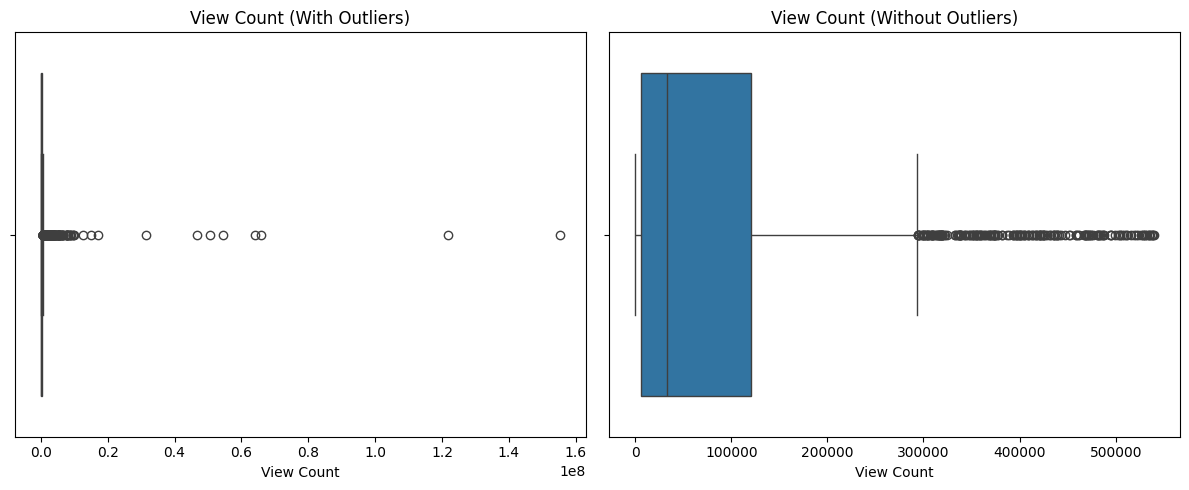

In [12]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=merged_data['View Count'])
plt.title('View Count (With Outliers)')

plt.subplot(1, 2, 2)
sns.boxplot(x=filtered_data['View Count'])
plt.title('View Count (Without Outliers)')

plt.tight_layout()
plt.show()

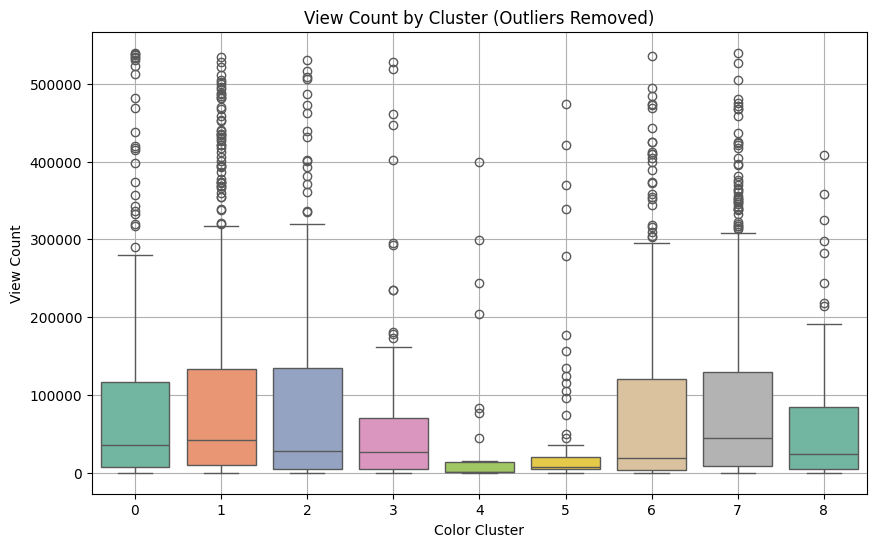

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='View Count', data=filtered_data, palette='Set2')
plt.title('View Count by Cluster (Outliers Removed)')
plt.xlabel('Color Cluster')
plt.ylabel('View Count')
plt.grid(True)
plt.show()

In [19]:
print(filtered_data.head(10))

        VideoID  Yellow  Orange   Red  Violet   Blue  Green  Black  White  \
0   --8n6A8Q6M0    0.00    0.71  0.00   23.29   0.06   0.00  13.58  13.01   
1   -0FfyNZdHk0    0.01    0.97  0.00   11.65   0.00   8.13  26.25  13.26   
2   -1B7cVoZr1c    0.84    0.61  0.00   16.56   7.08   0.00  14.65  32.05   
3   -4yu_13EHFM    0.00    8.72  0.00   25.99   0.00   0.00  14.83  10.53   
4   -6FvAU9H98w    0.11   10.24  0.70    6.79   0.04   0.00  12.74  39.01   
5   -7vF5F-1btE    0.64    2.76  1.08   22.39  14.17   0.00  16.90  11.52   
6   -9ACKA4sQ4U    0.00    5.48  0.00    5.10   0.00   0.00  30.14  23.86   
8   -fWzHd63UCA    0.25    1.84  0.00   11.64   0.00   0.00  44.48   9.39   
9   -GVbt3qdq70    0.00    1.78  0.09   14.24   0.28   0.09  33.25   2.88   
10  -JTkbbE_KP4    0.25    8.82  0.00   18.27   0.45   0.00   9.52   4.28   

    Brown Cluster  View Count  Like Count  Comment Count  \
0   49.35       1      338385       11044           1371   
1   39.73       5         147   

In [20]:
# --- 1. Ensure Column Names Are Valid ---
# Rename columns to remove spaces so they work with formula API
filtered_data.columns = filtered_data.columns.str.replace(' ', '')  # e.g., 'View Count' → 'ViewCount'

# Optional: Make sure Cluster is string/categorical
filtered_data['Cluster'] = filtered_data['Cluster'].astype(str)

# --- 2. Perform Weighted ANOVA Using WLS (Weighted Least Squares) ---

# Fit linear model using formula API
model = ols('ViewCount ~ Cluster', data=filtered_data).fit()

# Perform weighted regression using Channel_Weight
wls_model = sm.WLS(
    model.model.endog,         # Y variable (ViewCount)
    model.model.exog,          # X variables (Cluster dummies)
    weights=filtered_data['Channel_Weight']  # Apply channel weights
).fit()

# Print ANOVA-style summary
anova_table = sm.stats.anova_lm(wls_model, typ=2)
print("## Weighted ANOVA Results ##")
print(anova_table)

# Interpret result
p_value = anova_table.loc['Cluster', 'PR(>F)']
alpha = 0.05

if p_value < alpha:
    print(f"\nRESULT: There are statistically significant differences in View Count between clusters (p = {p_value:.4e}).")
else:
    print(f"\nRESULT: No significant differences in View Count between clusters (p = {p_value:.4e}).")

AttributeError: 'ModelData' object has no attribute 'design_info'